# QUARK Knapsack Plots

Messy Script to create plots for the Knapsack use case in QUARK

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import math
from matplotlib import ticker
import json
import seaborn as sns
from collections import defaultdict

In [2]:
#matplotlib.rc('text', usetex=True)
sns.set_style("whitegrid")

## Load in dataframe and do some adjustments

In [3]:
def process_quark_csv(filenames):
    dfs = []
    for filename in filenames:
        dfs.append(pd.read_csv(filename, index_col=0, encoding="utf-8"))
    df = pd.concat(dfs, axis=0, ignore_index=True)
    df['application_config'] = df.apply(lambda row: json.loads(row["application_config"]), axis=1)
    df['solver_config'] = df.apply(lambda row: json.loads(row["solver_config"]), axis=1)
    df['mapping_config'] = df.apply(lambda row: json.loads(row["mapping_config"]), axis=1)

    df['device'] = df['device'].replace({'simulatedannealer': 'Simulated Annealing', 'DW_2000Q_6': r"D-Wave 2000Q", 'Advantage_system4': r"D-Wave Advantage 4.1", 'Advantage_system6': r"D-Wave Advantage 6.1"})
    df['solver'] = df['solver'].replace({'SCIPKnapsack': 'SCIP', 'ReverseGreedyClassicalTSP': 'Reversed Greedy', "RandomTSP": "Random", "IterativeHeuristic": "IHS"})
    df = df.reset_index()
    
    column = df['application_config']
    affected_keys = []
    helper_dict = defaultdict(list)
    # Try to find out which key in the dict change
    for d in column.values:  # you can list as many input dicts as you want here
        for key, value in d.items():
            helper_dict[key].append(value)
            helper_dict[key] = list(set(helper_dict[key]))

    for key, value in helper_dict.items():
        # If there is more than 1 value and it is a float/int, then we can order it
        if len(value) > 1: #and isinstance(value[0], (int, float))
            affected_keys.append(key)

    if len(affected_keys) == 1:
        # X axis name should be this and fixed parameters in parenthesis
        df['applicationConfigCombo'] = df.apply(
            lambda row: row['application_config'][affected_keys[0]],
            axis=1)
        axis_name = f"{affected_keys[0]}" if len(
            helper_dict.keys()) == 1 else f"{affected_keys[0]} with {','.join(['%s %s' % (value[0], key) for (key, value) in helper_dict.items() if key not in affected_keys])}"

    else:
        df['applicationConfigCombo'] = df.apply(
            lambda row: '/\n'.join(['%s: %s' % (key, value) for (key, value) in row['application_config'].items() if
                                    key in affected_keys]), axis=1)

        axis_name = None

    df['applicationConfigCombo'] = df['applicationConfigCombo'].replace({'Scenario_1': 1,
 'Scenario_2': 2,
 'Scenario_3': 3,
 'Scenario_4': 4,
 'Scenario_5': 5,
 'Scenario_6': 6,
 'Scenario_7': 7,
 'Scenario_8': 8,
 'Scenario_9': 9,
 'Scenario_10': 10})
    
    df['configCombo'] = df.apply(lambda row: f"{row['mapping']}/\n{row['solver']}/\n{row['device']}", axis=1)
    def helper(device, solver):
        if solver == "IHS":
            if device =="Simulated Annealing":
                return r"{} with Sim. Anneal.".format(solver)
            else:
                return r"{} with {}".format(solver, device)
        elif device == "local":
            return r"{}".format(solver)
        else:
            return r"{}".format(device)

    def optimal_solution_helper(problem, solution):
        if problem == 1:
            return float(solution/22)
        elif problem == 2:
            return float(solution/12)
        elif problem == 3:
            return float(solution/13)
        elif problem == 4:
            return float(solution/13)
        elif problem == 5:
            return float(solution/16)
        elif problem == 6:
            return float(solution/17)
        elif problem == 7:
            return float(solution/20)
        elif problem == 8:
            return float(solution/22)
        elif problem == 9:
            return float(solution/51)
        elif problem == 10:
            return float(solution/1315)
    df['solverCombo'] = df.apply(lambda row: helper(row['device'], row['solver']), axis=1)

    df['difference_to_optimum_relative'] = df.apply(lambda row: optimal_solution_helper(row['applicationConfigCombo'], row['solution_quality']), axis=1)

    df['solverConfigCombo'] = df.apply(
        lambda row: '/\n'.join(
            ['%s: %s' % (key, value) for (key, value) in row['solver_config'].items()]) +
                    "\ndevice:" + row['device'] + "\nmapping:" + '/\n'.join(
            ['%s: %s' % (key, value) for (key, value) in row['mapping_config'].items()]), axis=1)
    
    # Convert to seconds
    df['time_to_solution'] = df['time_to_solution'].apply(lambda x: x/1000)
    
    df["problem_type"] = df.apply(lambda row: row['application_config']["problem_type"] , axis=1)
    df['problem_type'] = df['problem_type'].replace({'Scenario_1': 1,
 'Scenario_2': 2,
 'Scenario_3': 3,
 'Scenario_4': 4,
 'Scenario_5': 5,
 'Scenario_6': 6,
 'Scenario_7': 7,
 'Scenario_8': 8,
 'Scenario_9': 9,
 'Scenario_10': 10})
    
    return df
    
    

In [5]:
files = [ "results_annealing.csv"]
df = process_quark_csv(files)
df = df.loc[df["solverCombo"] != "SCIP"]

df = df.loc[df["problem_type"] != 10]

In [6]:
df_filtered = df.loc[df["mapping"] != "QutacQUBO"]

# Code to convert the lineplots for tikz for the Overleaf plots

In [7]:

color_map = {
    'D-Wave Advantage 6.1': 'RoyalBlue',
'D-Wave 2000Q': 'OrangeRed'
,'Simulated Annealing': 'YellowOrange'
, 'IHS with Sim. Anneal.': 'ForestGreen'
}
mark_map = {
    'D-Wave Advantage 6.1': 'diamond*',
'D-Wave 2000Q': 'square*'
,'Simulated Annealing': 'triangle*'
, 'IHS with Sim. Anneal.': '*'
}

def return_add_plot(values, color, mark):
    plot_string_values= [f"({x}, {mean}) +- ({std},{std}) \n" for (x, mean, std) in values]
    return  f"	\\addplot [color={color},  mark={mark}, mark size=1pt, mark options=solid, line width=1.2pt, error bars/.cd,y dir=both,y explicit] plot coordinates  {{\n{''.join(plot_string_values)} \n}};"


def get_tikz_data(df_target, x, y, hue, hue_order, factor=1):
    grouped = df_target.groupby([hue,x]).agg({y: ['mean', 'std']})

    group_2 = grouped.groupby(hue)
    # ugly_order
    ugly_order = {}
    for name, group in group_2:

        #print(name)
        x = [y for (x,y) in group.index.values]
        mean = [x *factor for x in group[y]['mean'].tolist()]
        std = [x *factor for x in group[y]['std'].tolist()]
        #print(list(zip(x, mean, std)))
        #print(return_add_plot(list(zip(x, mean, std)), color_map[name], mark_map[name]))
        ugly_order[name] = return_add_plot(list(zip(x, mean, std)), color_map[name], mark_map[name])

    for order in hue_order:
        print(ugly_order[order])


## Create the plot

In [8]:
def label_log_qubits(row):
    if row['applicationConfigCombo'] == 1 :
        return 12
    if row['applicationConfigCombo'] == 2 :
       return 14
    if row['applicationConfigCombo'] == 3 :
       return 16
    if row['applicationConfigCombo'] == 4 :
       return 19
    if row['applicationConfigCombo'] == 5 :
       return 23
    if row['applicationConfigCombo'] == 6 :
       return 27
    if row['applicationConfigCombo'] == 7 :
       return 31
    if row['applicationConfigCombo'] == 8 :
       return 36
    if row['applicationConfigCombo'] == 9 :
       return 42
df_filtered['logical_qubits'] = df_filtered.apply (lambda row: label_log_qubits(row), axis=1)

In [9]:
hue_order = [ 'D-Wave Advantage 6.1',  'D-Wave 2000Q','Simulated Annealing', 'IHS with Sim. Anneal.']


In [10]:
legend_flag = False

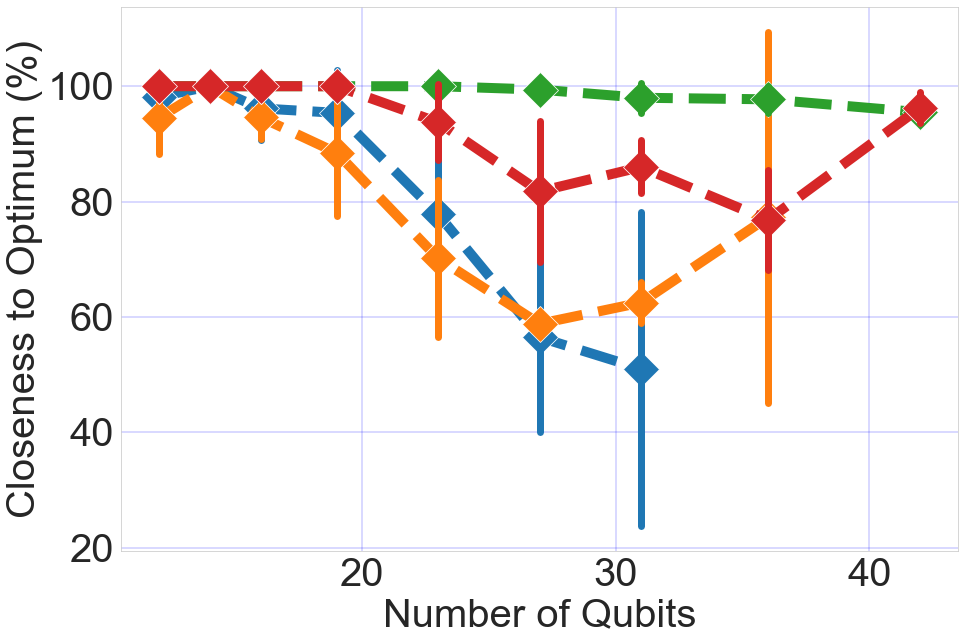

In [11]:
figname = f'knapsack_annealing_optimum.png'
factor=5
fig, ax = plt.subplots(1,1,figsize=(15,10))
sns.lineplot(data=df_filtered, x="logical_qubits", y="difference_to_optimum_relative", ax=ax, hue= 'solverCombo',hue_order=hue_order, ci = "sd", err_style="bars", marker='D',
            linewidth=2*factor,markersize=5*factor, linestyle='dashed', err_kws={"elinewidth": 7})

ax.set_xlabel('Number of Qubits', fontsize=8*factor)
ax.set_ylabel(f'Closeness to Optimum (%)', fontsize=8*factor)
ax.legend( fontsize=8*factor) #loc="upper right",
# change the line width for the legend
for line in ax.legend_.get_lines():
    line.set_linewidth(7.0)
for h in ax.legend_.legendHandles:
    h.set_marker('*')
    h.set_markersize(26)
ax.grid(color='b', linestyle='-', linewidth=0.3)
ax.tick_params(axis='both', which='major', labelsize=8*factor)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, symbol=None, decimals=0))

if legend_flag is False:
    ax.get_legend().remove()
fig.savefig(figname, bbox_inches='tight', dpi=100)

In [12]:
get_tikz_data(df_filtered, x="logical_qubits", y="difference_to_optimum_relative", hue= 'solverCombo', hue_order=hue_order, factor=100)

	\addplot [color=RoyalBlue,  mark=diamond*, mark size=1pt, mark options=solid, line width=1.2pt, error bars/.cd,y dir=both,y explicit] plot coordinates  {
(12, 98.18181818181819) +- (3.8330638305071267,3.8330638305071267) 
(14, 100.0) +- (0.0,0.0) 
(16, 96.15384615384615) +- (5.439282932204212,5.439282932204212) 
(19, 95.38461538461537) +- (7.4314752544561244,7.4314752544561244) 
(23, 77.77777777777779) +- (9.432692852226474,9.432692852226474) 
(27, 56.470588235294116) +- (16.4285176985517,16.4285176985517) 
(31, 51.0) +- (27.24885318687742,27.24885318687742) 
(36, nan) +- (nan,nan) 
(42, nan) +- (nan,nan) 
 
};
	\addplot [color=OrangeRed,  mark=square*, mark size=1pt, mark options=solid, line width=1.2pt, error bars/.cd,y dir=both,y explicit] plot coordinates  {
(12, 94.54545454545456) +- (6.356417261637281,6.356417261637281) 
(14, 100.0) +- (0.0,0.0) 
(16, 94.61538461538461) +- (3.715737627228059,3.715737627228059) 
(19, 88.46153846153847) +- (11.028622137234139,11.028622137234139) 


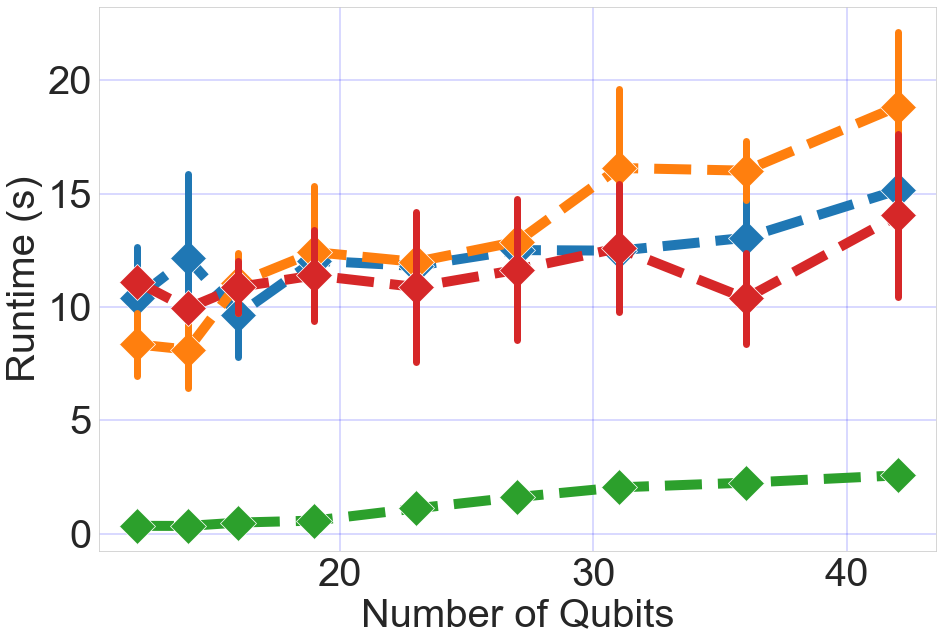

In [13]:
figname = f'knapsack_annealing_runtime.png'
factor=5
fig, ax = plt.subplots(1,1,figsize=(15,10))
sns.lineplot(data=df_filtered, x="logical_qubits", y="time_to_solution", ax=ax, hue= 'solverCombo',hue_order=hue_order, ci = "sd", err_style="bars", marker='D',
            linewidth=2*factor,markersize=5*factor, linestyle='dashed', err_kws={"elinewidth": 7})

ax.set_xlabel('Number of Qubits', fontsize=8*factor)
ax.set_ylabel(f'Runtime (s)', fontsize=8*factor)
ax.legend( fontsize=8*factor) #loc="upper right",
# change the line width for the legend
for line in ax.legend_.get_lines():
    line.set_linewidth(7.0)
for h in ax.legend_.legendHandles:
    h.set_marker('D')
    h.set_markersize(26)
ax.grid(color='b', linestyle='-', linewidth=0.3)
ax.tick_params(axis='both', which='major', labelsize=8*factor)
if legend_flag is False:
    ax.get_legend().remove()
fig.savefig(figname, bbox_inches='tight', dpi=100)

In [14]:
get_tikz_data(df_filtered, x="logical_qubits", y="time_to_solution", hue= 'solverCombo', hue_order=hue_order)

	\addplot [color=RoyalBlue,  mark=diamond*, mark size=1pt, mark options=solid, line width=1.2pt, error bars/.cd,y dir=both,y explicit] plot coordinates  {
(12, 10.4050904) +- (2.2176622841313076,2.2176622841313076) 
(14, 12.136053) +- (3.73858376606255,3.73858376606255) 
(16, 9.6570667) +- (1.869768613268916,1.869768613268916) 
(19, 12.0404543) +- (1.8018409606993033,1.8018409606993033) 
(23, 11.806983800000001) +- (1.3172444772475103,1.3172444772475103) 
(27, 12.5065015) +- (1.7529426569592594,1.7529426569592594) 
(31, 12.4799252) +- (1.359295569613729,1.359295569613729) 
(36, 13.049029) +- (1.782220180491301,1.782220180491301) 
(42, 15.148760200000002) +- (2.557460597644155,2.557460597644155) 
 
};
	\addplot [color=OrangeRed,  mark=square*, mark size=1pt, mark options=solid, line width=1.2pt, error bars/.cd,y dir=both,y explicit] plot coordinates  {
(12, 8.3485495) +- (1.399732950164602,1.399732950164602) 
(14, 8.1161515) +- (1.6710625192526296,1.6710625192526296) 
(16, 11.0559039) +

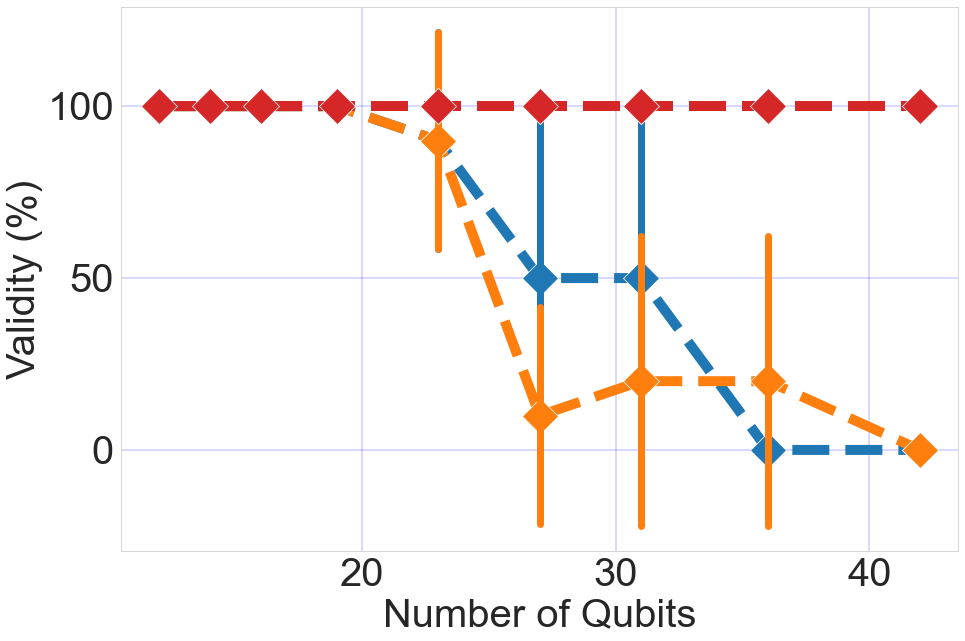

In [15]:
figname = f'knapsack_annealing_validity.png'
factor=5
fig, ax = plt.subplots(1,1,figsize=(15,10))
sns.lineplot(data=df_filtered, x="logical_qubits", y="solution_validity", ax=ax, hue= 'solverCombo',hue_order=hue_order, ci = "sd", err_style="bars", marker='D',
            linewidth=2*factor,markersize=5*factor, linestyle='dashed', err_kws={"elinewidth": 7})

ax.set_xlabel('Number of Qubits', fontsize=8*factor)
ax.set_ylabel(f'Validity (%)', fontsize=8*factor)
ax.legend( fontsize=8*factor) #loc="upper right",
# change the line width for the legend
for line in ax.legend_.get_lines():
    line.set_linewidth(7.0)
for h in ax.legend_.legendHandles:
    h.set_marker('D')
    h.set_markersize(26)
ax.grid(color='b', linestyle='-', linewidth=0.3)
ax.tick_params(axis='both', which='major', labelsize=8*factor)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, symbol=None, decimals=0))
if legend_flag is False:
    ax.get_legend().remove()

fig.savefig(figname, bbox_inches='tight', dpi=100)

## Save legend seperate image

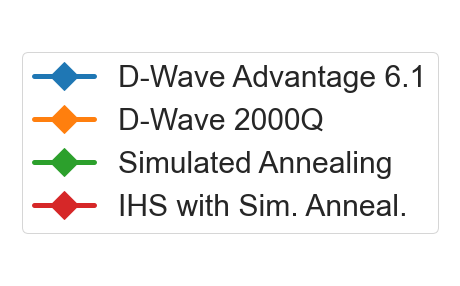

In [16]:
# then create a new image
# adjust the figure size as necessary
figsize = (8, 5)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)
# add the legend from the previous axes
ax_leg.legend(*ax.get_legend_handles_labels(), loc='center', prop={'size': 30})
for line in ax_leg.legend_.get_lines():
    line.set_linewidth(5.0)
for h in ax_leg.legend_.legendHandles:
    h.set_marker('D')
    h.set_markersize(20)
# hide the axes frame and the x/y labels
ax_leg.axis('off')
fig_leg.savefig('legend.png')

## Now we need to calculate c_opt

Init application
init mapping
Reverse map bitstrings
check if valid
evaluate
check if > threshold of 90%
add to count

In [17]:
df_filtered['additional_solver_information'] = df_filtered.apply(lambda row: json.loads(row["additional_solver_information"]), axis=1)


In [18]:
df_filtered["full_response"] = df_filtered.apply(lambda row: row['additional_solver_information']["full_response"] if "full_response" in row['additional_solver_information'] else [], axis=1)

In [20]:
import sys
# Here you need to point to the KnapsackRebased branch from QUARK
sys.path.append("/Users/user/git_repos/QUARK")
from src.applications.Knapsack.Knapsack import Knapsack
from src.applications.Knapsack.mappings.MultiKSQUBO import MultiKSQUBO

def optimal_solution(problem):
        if problem == 1:
            return float(22)
        elif problem == 2:
            return float(12)
        elif problem == 3:
            return float(13)
        elif problem == 4:
            return float(13)
        elif problem == 5:
            return float(16)
        elif problem == 6:
            return float(17)
        elif problem == 7:
            return float(20)
        elif problem == 8:
            return float(22)
        elif problem == 9:
            return float(51)
        elif problem == 10:
            return float(1315)

def calculate_c_opt(row):
    threshold = 0.9
    application = Knapsack()
    problem = application.generate_problem({"problem_type":  f"Scenario_{row['problem_type']}"})
    mapping = MultiKSQUBO()

    mapping.map(problem, config={"penalty_alpha":20, "penalty_beta":5,"penalty_gamma":1})
    occurences = 0

    if len(row["full_response"])> 0 :

        for entry in row["full_response"]:
            reversed_mapped, _ = mapping.reverse_map({k: v for k, v in enumerate(entry["bitstring"])})

            valid, _ = application.validate(reversed_mapped)

            if valid:
                packed_valued, _ = application.evaluate(reversed_mapped)
                if packed_valued >= optimal_solution(row["problem_type"])*threshold:
                    occurences = occurences + entry["num_occurences"]
    return math.sqrt(occurences/1000)

df_filtered['c_opt'] = df_filtered.apply(lambda row: calculate_c_opt(row), axis=1)

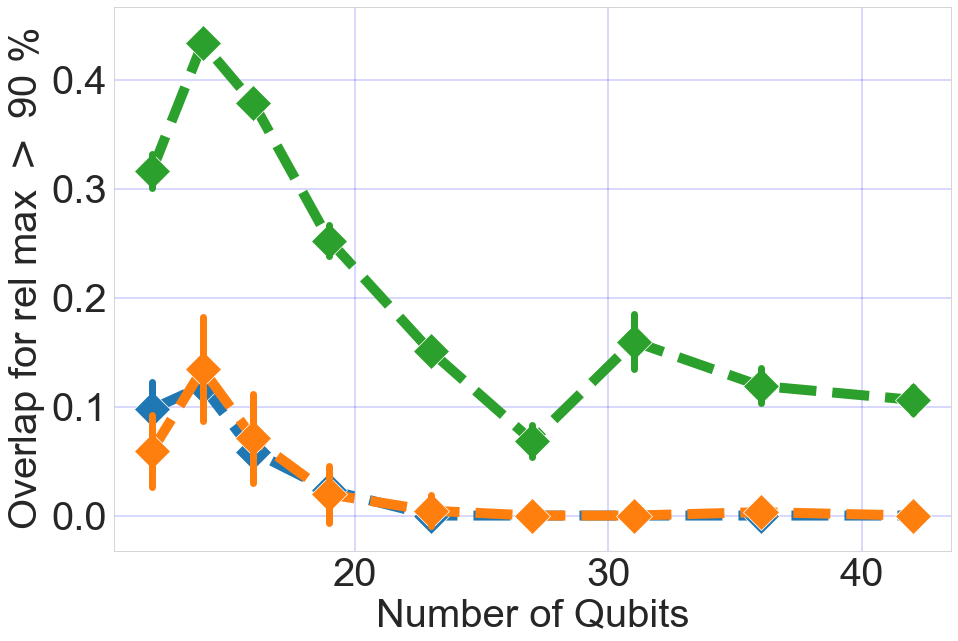

In [21]:
figname = f'knapsack_annealing_c_opt.png'
hue_order_without_ihs = ['D-Wave Advantage 6.1', 'D-Wave 2000Q', 'Simulated Annealing']
factor=5
fig, ax = plt.subplots(1,1,figsize=(15,10))
sns.lineplot(data=df_filtered.loc[df_filtered["solver"] != "IHS"], x="logical_qubits", y="c_opt", ax=ax, hue= 'solverCombo',hue_order=hue_order_without_ihs, ci = "sd", err_style="bars",
            linewidth=2*factor,markersize=5*factor, linestyle='dashed', err_kws={"elinewidth": 7}, marker='D')

ax.set_xlabel('Number of Qubits', fontsize=8*factor)
ax.set_ylabel(f'Overlap for rel max $>$ 90 %', fontsize=8*factor)
ax.legend(loc="upper right", fontsize=8*factor)
# change the line width for the legend
for line in ax.legend_.get_lines():
    line.set_linewidth(7.0)
for h in ax.legend_.legendHandles:
    h.set_marker('D')
    h.set_markersize(26)


ax.grid(color='b', linestyle='-', linewidth=0.3)
ax.tick_params(axis='both', which='major', labelsize=8*factor)
if legend_flag is False:
    ax.get_legend().remove()
fig.savefig(figname, bbox_inches='tight', dpi=100)

In [22]:
get_tikz_data(df_target=df_filtered.loc[df_filtered["solver"] != "IHS"], x="logical_qubits", y="c_opt",hue= 'solverCombo',  hue_order=hue_order_without_ihs, factor=1)

	\addplot [color=RoyalBlue,  mark=diamond*, mark size=1pt, mark options=solid, line width=1.2pt, error bars/.cd,y dir=both,y explicit] plot coordinates  {
(12, 0.09767979088731675) +- (0.024914486018514287,0.024914486018514287) 
(14, 0.11882052806752921) +- (0.02947092936274479,0.02947092936274479) 
(16, 0.058635169002042076) +- (0.027119426331649012,0.027119426331649012) 
(19, 0.023445801916009854) +- (0.01667647619703437,0.01667647619703437) 
(23, 0.0) +- (0.0,0.0) 
(27, 0.0) +- (0.0,0.0) 
(31, 0.0) +- (0.0,0.0) 
(36, 0.0) +- (0.0,0.0) 
(42, 0.0) +- (0.0,0.0) 
 
};
	\addplot [color=OrangeRed,  mark=square*, mark size=1pt, mark options=solid, line width=1.2pt, error bars/.cd,y dir=both,y explicit] plot coordinates  {
(12, 0.05935688748494885) +- (0.0329437215076986,0.0329437215076986) 
(14, 0.13441881029392516) +- (0.047511208492379976,0.047511208492379976) 
(16, 0.07074024678938495) +- (0.040767872483896385,0.040767872483896385) 
(19, 0.01943619451055638) +- (0.02629394402071021,0.02